In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
tf.keras.backend.clear_session()

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
subject = 'Rondônia - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,13.867,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,10.777,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,13.888,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,11.859,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,14.431,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


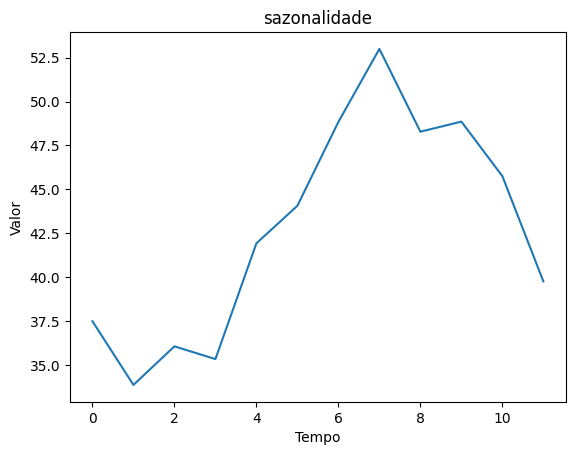

,sazonalidade
sazonalidade,
0,37.484568
1,33.856379
2,36.053154
3,35.327587
4,41.923759
5,44.063440
6,48.840487
7,52.998027
8,48.282743


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062,37.484568,13.867
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943,33.856379,10.777
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823,36.053154,13.888
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703,35.327587,11.859
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584,41.923759,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.923759,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.063440,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.840487,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.998027,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rondônia - Consumo de Cimento (t), Length: 249, dtype: float64

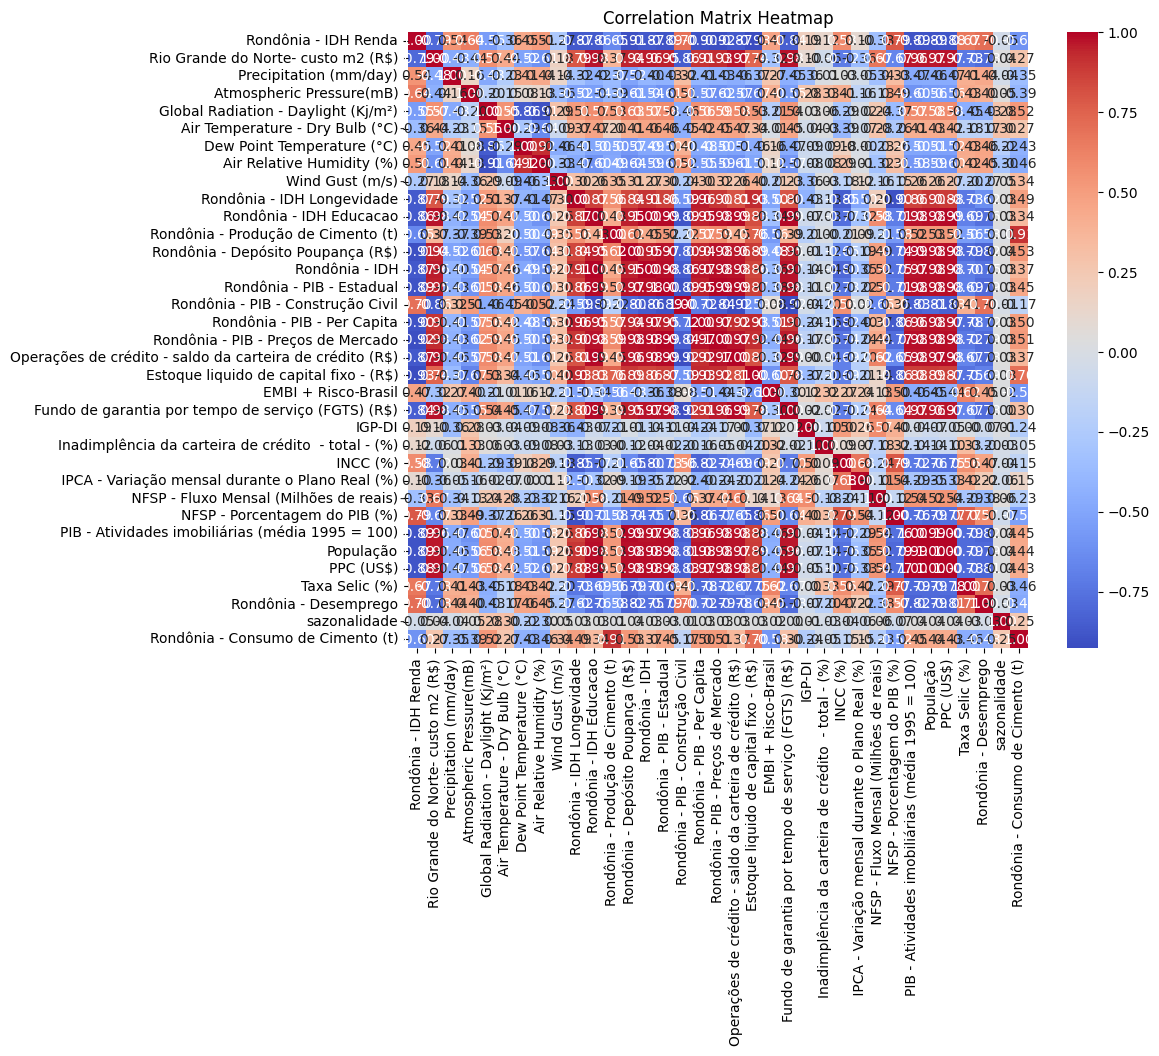

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rondônia - IDH Renda,4.413923e+02
1,Rio Grande do Norte- custo m2 (R$),5.315272e+04
2,Precipitation (mm/day),6.444849e+00
3,Atmospheric Pressure(mB),2.187338e+05
4,Global Radiation - Daylight (Kj/m²),1.375884e+03
5,Air Temperature - Dry Bulb (°C),5.083587e+02
6,Dew Point Temperature (°C),1.721227e+03
7,Air Relative Humidity (%),3.124640e+03
8,Wind Gust (m/s),8.570957e+01
9,Rondônia - IDH Longevidade,5.437469e+08


In [39]:
# data =data.drop(['Rondônia - IDH Educacao',
#                  'IGP-DI', 
#                  'Rondônia - IDH',
#                  'Inadimplência da carteira de crédito  - total - (%)',
#                  ' INCC (%)',
#                  'População',
#                  'PIB - Atividades imobiliárias (média 1995 = 100)',
#                  'Operações de crédito - saldo da carteira de crédito (R$)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 1


,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
0,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987000,5.714165e+05,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062,37.484568
1,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987000,5.760053e+05,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943,33.856379
2,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987000,5.805941e+05,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823,36.053154
3,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987000,5.851830e+05,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703,35.327587
4,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987000,5.897718e+05,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584,41.923759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.692959,25198.273978,0.832490,1001.057494,1382.155589,26.428498,20.871291,74.103171,0.723780,0.753194,0.693524,19.901325,2.203492e+06,2.478205e+07,1.491002e+06,11.794843,1.922760e+07,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,6.902958,52.998027
200,0.692837,25374.248816,0.815919,1000.244082,1404.792046,26.283630,21.467515,76.443393,0.716131,0.752994,0.693427,19.998192,2.237369e+06,2.475866e+07,1.492473e+06,11.792861,1.922253e+07,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,6.888487,48.282743
201,0.692714,25558.432434,0.732411,999.944284,1420.575253,25.998552,21.593253,77.803124,0.712612,0.752794,0.693330,19.946447,2.271246e+06,2.473526e+07,1.493943e+06,11.790878,1.921746e+07,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,6.874016,48.856456
202,0.692591,25749.144058,0.717922,999.809172,1437.19

In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,-1.549632,0.419951,1.599447,-0.142904,-0.474099,-0.420206,-0.185664,0.098848,-2.816824,-1.708141,-1.138547,-1.663188,-1.744325,0.417276,-2.473220,-2.002524,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,1.289810
1,-1.529261,0.417628,1.592081,-0.141011,-0.472683,-0.420182,-0.186082,0.100180,-2.755892,-1.692284,-1.138547,-1.654439,-1.726460,0.442259,-2.430236,-1.973367,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,1.277051
2,-1.509995,0.416272,1.587784,-0.139907,-0.471857,-0.420168,-0.186326,0.100956,-2.694959,-1.676428,-1.138547,-1.645690,-1.708595,0.467242,-2.387252,-1.944209,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,1.264293
3,-1.492208,0.416127,1.587324,-0.139788,-0.471769,-0.420167,-0.186352,0.101039,-2.634027,-1.660571,-1.138547,-1.636940,-1.690730,0.492225,-2.344268,-1.915052,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,1.251535
4,-1.475726,0.424041,1.573194,-0.150593,-0.465489,-0.398023,-0.170380,0.084455,-2.573094,-1.644715,-1.138547,-1.628191,-1.672864,0.517208,-2.301283,-1.885894,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,1.238776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.884020,-3.409049,0.305702,0.890509,0.337973,-1.262448,-1.235121,-1.682020,0.257094,1.225622,-0.128269,1.448615,0.955550,-0.891033,0.799511,0.827508,1.360064,0.117681,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268,-1.468581
200,1.923631,-3.436869,0.216801,1.048448,0.108730,-0.795587,-0.853298,-1.705270,0.215654,1.220670,-0.121707,1.513208,0.940139,-0.871132,0.779653,0.812321,1.384545,0.092456,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925,-1.498750
201,1.965090,-3.577073,0.184035,1.158571,-0.342382,-0.697130,-0.631449,-1.715964,0.174215,1.215718,-0.125212,1.577800,0.924729,-0.851232,0.759795,0.797133,1.413764,0.067231,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663,-1.528919
202,2.008018,-3.601397,0.169268,1.274520,-0.368359,-0.639845,-0.587917,-1.722370,0.132775,1.210767,-0.121321,1.642393,0.909319,-0.831331,0.739936,0.781946,1.440408,0.042006,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340,-1.559087


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,-1.549632,0.419951,1.599447,-0.142904,-0.474099,-0.420206,-0.185664,0.098848,-2.816824,-1.708141,-1.138547,-1.663188,-1.744325,0.417276,-2.473220,-2.002524,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,1.289810
1,-1.529261,0.417628,1.592081,-0.141011,-0.472683,-0.420182,-0.186082,0.100180,-2.755892,-1.692284,-1.138547,-1.654439,-1.726460,0.442259,-2.430236,-1.973367,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,1.277051
2,-1.509995,0.416272,1.587784,-0.139907,-0.471857,-0.420168,-0.186326,0.100956,-2.694959,-1.676428,-1.138547,-1.645690,-1.708595,0.467242,-2.387252,-1.944209,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,1.264293
3,-1.492208,0.416127,1.587324,-0.139788,-0.471769,-0.420167,-0.186352,0.101039,-2.634027,-1.660571,-1.138547,-1.636940,-1.690730,0.492225,-2.344268,-1.915052,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,1.251535
4,-1.475726,0.424041,1.573194,-0.150593,-0.465489,-0.398023,-0.170380,0.084455,-2.573094,-1.644715,-1.138547,-1.628191,-1.672864,0.517208,-2.301283,-1.885894,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,1.238776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.558767,1.552901,0.200378,1.504292,1.403768,-1.088472,-1.493582,0.679505,0.715523,1.279433,-0.244874,1.018608,1.105915,-1.125207,1.025891,0.985371,1.193119,0.391058,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820,-1.128903
188,1.577774,1.327908,0.196717,1.028284,1.210034,-0.784532,-1.175398,0.695251,0.681853,1.275603,-0.237113,1.014180,1.097416,-1.106233,1.008416,0.975060,1.206925,0.371698,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503,-1.154603
189,1.597766,0.809503,0.222364,0.438951,0.768204,-0.439499,-0.715497,0.690225,0.648182,1.271774,-0.214796,1.009752,1.088918,-1.087258,0.990941,0.964750,1.227934,0.352338,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444,-1.180302
190,1.618228,0.877808,0.247596,0.105256,0.403599,-0.245089,-0.410607,0.400064,0.614512,1.267944,-0.215630,1.005324,1.080419,-1.068284,0.973467,0.954439,1.246115,0.332977,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935,-1.206001


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
187    55.415
188    51.237
189    50.201
190    37.203
191    31.209
Name: Rondônia - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 31)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
156,0.858648,0.468304,-0.835091,0.581225,1.321649,0.441757,-0.178329,0.184726,1.510057,1.303990,-0.058035,0.695802,1.148751,-1.445503,0.969042,1.093630,1.222613,0.845472,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265,0.075651
157,0.880002,0.943568,-0.868266,0.563667,0.981410,0.448188,-0.024282,0.036338,1.490036,1.305560,-0.079592,0.704105,1.153988,-1.440294,0.988602,1.100459,1.211968,0.833972,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084,0.012834
158,0.902470,0.772527,-0.785461,0.481875,0.398726,0.246548,0.057025,-0.047594,1.470015,1.307131,-0.099106,0.712408,1.159225,-1.435086,1.008162,1.107289,1.202030,0.822472,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087,-0.049983
159,0.925187,-0.000479,-0.564486,0.836122,0.172396,-0.291711,-0.249828,-0.115562,1.449994,1.308701,-0.118186,0.720711,1.164462,-1.429877,1.027723,1.114118,1.192181,0.810972,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300,-0.112801
160,0.948519,-0.596347,-0.289042,0.903699,-0.007131,-0.774333,-0.531073,-0.175380,1.429973,1.310271,-0.134251,0.729014,1.169700,-1.424668,1.047283,1.120948,1.183708,0.799472,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403,-0.175618
161,0.971651,-0.758937,-0.085435,1.119133,-0.056369,-1.146351,-0.818632,-0.094690,1.409952,1.311841,-0.140901,0.737317,1.174937,-1.419460,1.066843,1.127777,1.174004,0.787972,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434,-0.238435
162,0.996138,-0.599691,0.003543,1.333356,0.355476,-1.216606,-1.036951,-0.028075,1.389931,1.313411,-0.148602,0.745619,1.180174,-1.414251,1.086403,1.134606,1.166949,0.776472,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553,-0.301253
163,1.021262,-0.223381,-0.050275,1.172547,0.498805,-0.901494,-0.881221,0.062659,1.369910,1.314981,-0.143876,0.753922,1.185411,-1.409043,1.105963,1.141436,1.159632,0.764972,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038,-0.364070
164,1.045964,-0.237532,-0.142252,0.975320,0.470053,-0.579896,-0.652830,0.172591,1.349889,1.316551,-0.140975,0.762225,1.190648,-1.403834,1.125523,1.148265,1.154709,0.753473,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412,-0.426887
165,1.071387,-0.456864,-0.267320,0.697804,0.409460,-0.347692,-0.443024,0.201708,1.329868,1.318121,-0.139017,0.770528,1.195886,-1.398625,1.145083,1.155094,1.151483,0.741973,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.002592,1.025524,0.367764,-0.489705


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 31)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[492630292, 3551767969, 2240524309, 603299131, 1327363866, 3801701035, 98302541, 3388814264, 3757040274, 286552350]


Step: 0 ___________________________________________
val_loss: 40.28823471069336
winner_seed: 492630292


Step: 1 ___________________________________________
val_loss: 29.85472869873047
winner_seed: 3551767969


Step: 2 ___________________________________________
val_loss: 28.58207893371582
winner_seed: 2240524309


Step: 3 ___________________________________________
val_loss: 31.270851135253906


Step: 4 ___________________________________________
val_loss: 31.760276794433594


Step: 5 ___________________________________________
val_loss: 20.033964157104492
winner_seed: 3801701035


Step: 6 ___________________________________________
val_loss: 22.980606079101562


Step: 7 ___________________________________________
val_loss: 33.636085510253906


Step: 8 ___________________________________________
val_loss: 23.355649948120117


Step: 9 ___________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 86ms/step - loss: 2372.7207 - val_loss: 105.4579
Epoch 2/10000
5/5 [==============================] - 0s 6ms/step - loss: 524.1564 - val_loss: 347.5221
Epoch 3/10000
5/5 [==============================] - 0s 6ms/step - loss: 434.9951 - val_loss: 2086.1978
Epoch 4/10000
5/5 [==============================] - 0s 6ms/step - loss: 779.7689 - val_loss: 72.0673
Epoch 5/10000
5/5 [==============================] - 0s 7ms/step - loss: 408.6973 - val_loss: 199.8832
Epoch 6/10000
5/5 [==============================] - 0s 6ms/step - loss: 485.9116 - val_loss: 993.9333
Epoch 7/10000
5/5 [==============================] - 0s 6ms/step - loss: 1082.0986 - val_loss: 1797.8827
Epoch 8/10000
5/5 [==============================] - 0s 8ms/step - loss: 426.2679 - val_loss: 1320.1688
Epoch 9/10000
5/5 [==============================] - 0s 8ms/step - loss: 180.6412 - val_loss: 1319.6533
Epoch 10/10000
5/5 [==============================] - 0s 7ms/step -

5/5 [==============================] - 0s 8ms/step - loss: 37.8527 - val_loss: 29.5284
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 58.6714 - val_loss: 24.8279
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 58.9939 - val_loss: 26.4070
Epoch 84/10000
5/5 [==============================] - 0s 8ms/step - loss: 49.0268 - val_loss: 75.3995
Epoch 85/10000
5/5 [==============================] - 0s 8ms/step - loss: 48.7087 - val_loss: 26.8574
Epoch 86/10000
5/5 [==============================] - 0s 8ms/step - loss: 43.2637 - val_loss: 24.1224
Epoch 87/10000
5/5 [==============================] - 0s 8ms/step - loss: 40.2459 - val_loss: 27.6513
Epoch 88/10000
5/5 [==============================] - 0s 8ms/step - loss: 38.1555 - val_loss: 27.8622
Epoch 89/10000
5/5 [==============================] - 0s 8ms/step - loss: 38.3918 - val_loss: 28.3099
Epoch 90/10000
5/5 [==============================] - 0s 8ms/step - loss: 34.8380 - val_loss: 43.

Epoch 161/10000
5/5 [==============================] - 0s 8ms/step - loss: 31.9323 - val_loss: 35.3725
Epoch 162/10000
5/5 [==============================] - 0s 8ms/step - loss: 48.4915 - val_loss: 61.7841
Epoch 163/10000
5/5 [==============================] - 0s 9ms/step - loss: 33.4910 - val_loss: 57.8723
Epoch 164/10000
5/5 [==============================] - 0s 9ms/step - loss: 37.7517 - val_loss: 46.1984
Epoch 165/10000
5/5 [==============================] - 0s 8ms/step - loss: 31.4950 - val_loss: 35.6897
Epoch 166/10000
5/5 [==============================] - 0s 8ms/step - loss: 35.4125 - val_loss: 53.1884
Epoch 167/10000
5/5 [==============================] - 0s 9ms/step - loss: 34.4204 - val_loss: 56.0754
Epoch 168/10000
5/5 [==============================] - 0s 9ms/step - loss: 30.8506 - val_loss: 37.4170
Epoch 169/10000
5/5 [==============================] - 0s 8ms/step - loss: 30.8697 - val_loss: 44.0053
Epoch 170/10000
5/5 [==============================] - 0s 8ms/step - loss

5/5 [==============================] - 0s 8ms/step - loss: 26.5172 - val_loss: 29.6775
Epoch 241/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.4465 - val_loss: 27.2854
Epoch 242/10000
5/5 [==============================] - 0s 8ms/step - loss: 29.3614 - val_loss: 24.5137
Epoch 243/10000
5/5 [==============================] - 0s 8ms/step - loss: 28.1779 - val_loss: 28.9708
Epoch 244/10000
5/5 [==============================] - 0s 8ms/step - loss: 34.7565 - val_loss: 26.7585
Epoch 245/10000
5/5 [==============================] - 0s 9ms/step - loss: 27.3108 - val_loss: 36.4445
Epoch 246/10000
5/5 [==============================] - 0s 9ms/step - loss: 28.1689 - val_loss: 27.3397
Epoch 247/10000
5/5 [==============================] - 0s 9ms/step - loss: 32.4322 - val_loss: 26.2178
Epoch 248/10000
5/5 [==============================] - 0s 8ms/step - loss: 31.5941 - val_loss: 22.4945
Epoch 249/10000
5/5 [==============================] - 0s 8ms/step - loss: 33.1540 - val_

5/5 [==============================] - 0s 8ms/step - loss: 24.6136 - val_loss: 24.2141
Epoch 320/10000
5/5 [==============================] - 0s 8ms/step - loss: 29.2198 - val_loss: 26.5380
Epoch 321/10000
5/5 [==============================] - 0s 8ms/step - loss: 21.5689 - val_loss: 21.8895
Epoch 322/10000
5/5 [==============================] - 0s 8ms/step - loss: 23.5926 - val_loss: 25.3838
Epoch 323/10000
5/5 [==============================] - 0s 8ms/step - loss: 27.3622 - val_loss: 33.5923
Epoch 324/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.6553 - val_loss: 25.0043
Epoch 325/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.4815 - val_loss: 24.6383
Epoch 326/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.6579 - val_loss: 24.8336
Epoch 327/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.6848 - val_loss: 25.9097
Epoch 328/10000
5/5 [==============================] - 0s 8ms/step - loss: 28.8163 - val_

5/5 [==============================] - 0s 7ms/step - loss: 19.9216 - val_loss: 27.5555
Epoch 399/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.6108 - val_loss: 27.0209
Epoch 400/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.9052 - val_loss: 25.7617
Epoch 401/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.5973 - val_loss: 24.2723
Epoch 402/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.5088 - val_loss: 26.8077
Epoch 403/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.2764 - val_loss: 27.0510
Epoch 404/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.1957 - val_loss: 26.0884
Epoch 405/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.3282 - val_loss: 24.6523
Epoch 406/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.5972 - val_loss: 25.3196
Epoch 407/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.1606 - val_

5/5 [==============================] - 0s 9ms/step - loss: 17.0718 - val_loss: 24.8489
Epoch 478/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.2262 - val_loss: 25.6491
Epoch 479/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.5408 - val_loss: 25.0720
Epoch 480/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.9568 - val_loss: 24.9769
Epoch 481/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.0618 - val_loss: 29.2222
Epoch 482/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.8432 - val_loss: 25.1188
Epoch 483/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.4426 - val_loss: 26.1990
Epoch 484/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.5737 - val_loss: 25.7380
Epoch 485/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.1866 - val_loss: 27.6044
Epoch 486/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.9618 - val_

5/5 [==============================] - 0s 8ms/step - loss: 15.3803 - val_loss: 24.5005
Epoch 557/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.7663 - val_loss: 23.9994
Epoch 558/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.1214 - val_loss: 24.6658
Epoch 559/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.9179 - val_loss: 21.7824
Epoch 560/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.5096 - val_loss: 22.7690
Epoch 561/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.5816 - val_loss: 23.1300
Epoch 562/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.0098 - val_loss: 23.4034
Epoch 563/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.6581 - val_loss: 22.4256
Epoch 564/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.3028 - val_loss: 24.9798
Epoch 565/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.1910 - val_

5/5 [==============================] - 0s 9ms/step - loss: 13.7260 - val_loss: 24.7757
Epoch 636/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.3088 - val_loss: 23.9487
Epoch 637/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.7655 - val_loss: 29.3195
Epoch 638/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.0508 - val_loss: 23.9763
Epoch 639/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.3357 - val_loss: 24.0196
Epoch 640/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.3432 - val_loss: 25.8904
Epoch 641/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.3637 - val_loss: 23.6761
Epoch 642/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.2919 - val_loss: 24.1256
Epoch 643/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.9158 - val_loss: 27.1437
Epoch 644/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.7336 - val_

5/5 [==============================] - 0s 8ms/step - loss: 12.0073 - val_loss: 28.0365
Epoch 715/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.8354 - val_loss: 24.4057
Epoch 716/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.2510 - val_loss: 22.5073
Epoch 717/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.6590 - val_loss: 30.6012
Epoch 718/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.6469 - val_loss: 25.3318
Epoch 719/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.8147 - val_loss: 27.2377
Epoch 720/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.0492 - val_loss: 24.0459
Epoch 721/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.1185 - val_loss: 27.3224
Epoch 722/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.5149 - val_loss: 24.8511
Epoch 723/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.1725 - val_

5/5 [==============================] - 0s 7ms/step - loss: 11.1053 - val_loss: 27.2570
Epoch 794/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.6937 - val_loss: 26.2851
Epoch 795/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.2486 - val_loss: 24.8339
Epoch 796/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.6903 - val_loss: 22.6811
Epoch 797/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.3372 - val_loss: 25.7924
Epoch 798/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.3691 - val_loss: 25.2601
Epoch 799/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.3042 - val_loss: 27.7213
Epoch 800/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.1895 - val_loss: 31.8904
Epoch 801/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.0628 - val_loss: 27.8350
Epoch 802/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.0088 - val_

Epoch 873/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.7792 - val_loss: 26.5630
Epoch 874/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.7461 - val_loss: 29.0764
Epoch 875/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.5162 - val_loss: 26.8488
Epoch 876/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.0406 - val_loss: 27.1479
Epoch 877/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.7280 - val_loss: 22.9192
Epoch 878/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.2051 - val_loss: 24.7269
Epoch 879/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6843 - val_loss: 32.3795
Epoch 880/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.1548 - val_loss: 27.6712
Epoch 881/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.0588 - val_loss: 29.2425
Epoch 882/10000
5/5 [==============================] - 0s 8ms/step - loss:

Epoch 953/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.3186 - val_loss: 23.1389
Epoch 954/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.5773 - val_loss: 23.4128
Epoch 955/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.6914 - val_loss: 23.5077
Epoch 956/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.4959 - val_loss: 26.5648
Epoch 957/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.9564 - val_loss: 25.2128
Epoch 958/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.7227 - val_loss: 26.2528
Epoch 959/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.5331 - val_loss: 25.0071
Epoch 960/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.9993 - val_loss: 26.8615
Epoch 961/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.7524 - val_loss: 28.3593
Epoch 962/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.3

5/5 [==============================] - 0s 8ms/step - loss: 13.7699 - val_loss: 29.9135
Epoch 1033/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.5049 - val_loss: 27.1475
Epoch 1034/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.9469 - val_loss: 28.6165
Epoch 1035/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.3202 - val_loss: 30.1868
Epoch 1036/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.9029 - val_loss: 28.5951
Epoch 1037/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.7156 - val_loss: 28.1273
Epoch 1038/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.6073 - val_loss: 32.9907
Epoch 1039/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.3438 - val_loss: 33.1247
Epoch 1040/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.9583 - val_loss: 29.0476
Epoch 1041/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.5541 - val

5/5 [==============================] - 0s 8ms/step - loss: 9.2936 - val_loss: 37.2362
Epoch 1112/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.9291 - val_loss: 35.3578
Epoch 1113/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.3087 - val_loss: 35.1031
Epoch 1114/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.6204 - val_loss: 35.7029
Epoch 1115/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.1403 - val_loss: 41.5322
Epoch 1116/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.9382 - val_loss: 37.4713
Epoch 1117/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.2178 - val_loss: 36.5652
Epoch 1118/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.6800 - val_loss: 46.0659
Epoch 1119/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.4456 - val_loss: 40.7644
Epoch 1120/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.7989 - 

5/5 [==============================] - 0s 8ms/step - loss: 7.9715 - val_loss: 38.3104
Epoch 1191/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.3311 - val_loss: 36.1413
Epoch 1192/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.8218 - val_loss: 37.2325
Epoch 1193/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.2382 - val_loss: 38.5089
Epoch 1194/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.3288 - val_loss: 35.1916
Epoch 1195/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.8531 - val_loss: 39.9226
Epoch 1196/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.6363 - val_loss: 35.6801
Epoch 1197/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.6785 - val_loss: 33.8601
Epoch 1198/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.4754 - val_loss: 35.6506
Epoch 1199/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.5459 - val

5/5 [==============================] - 0s 7ms/step - loss: 6.0655 - val_loss: 40.8834
Epoch 1270/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.3795 - val_loss: 44.1197
Epoch 1271/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.5499 - val_loss: 46.5666
Epoch 1272/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.3870 - val_loss: 49.0367
Epoch 1273/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.4970 - val_loss: 40.4354
Epoch 1274/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.2142 - val_loss: 44.2225
Epoch 1275/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.8378 - val_loss: 46.5917
Epoch 1276/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.3325 - val_loss: 47.3233
Epoch 1277/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.9975 - val_loss: 46.0415
Epoch 1278/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.8589 - val_l

5/5 [==============================] - 0s 7ms/step - loss: 7.3283 - val_loss: 45.9710
Epoch 1349/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.6017 - val_loss: 45.7632
Epoch 1350/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.2469 - val_loss: 50.2534
Epoch 1351/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.2735 - val_loss: 43.8516
Epoch 1352/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.8051 - val_loss: 42.3531
Epoch 1353/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.9887 - val_loss: 42.1036
Epoch 1354/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.1654 - val_loss: 43.9497
Epoch 1355/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.6900 - val_loss: 42.9566
Epoch 1356/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.7475 - val_loss: 50.0102
Epoch 1357/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.5333 - val_

5/5 [==============================] - 0s 7ms/step - loss: 6.2095 - val_loss: 48.5500
Epoch 1428/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.7552 - val_loss: 46.5318
Epoch 1429/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.8132 - val_loss: 45.5802
Epoch 1430/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.5512 - val_loss: 43.4216
Epoch 1431/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.1487 - val_loss: 45.3691
Epoch 1432/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.5532 - val_loss: 42.4488
Epoch 1432: early stopping


In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.328175,29.987879,30.445408,32.102692,34.877995,36.505428,38.325691,39.984612,39.732632,38.561005,37.338505,36.230244
Target,35.615,32.034,36.93,38.24,44.66,43.439,46.9,49.678,52.707,45.872,40.769,35.98
Error,5.286827,2.046122,6.484592,6.13731,9.782005,6.933571,8.57431,9.69339,12.974369,7.310997,3.430496,0.250244


In [54]:
display(mae)
display(mape)

6.575352

0.15013634

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[424.4203]] - Target[502.824]| =  Error: [[78.40372]]; MAPE:[[0.15592676]]


[array([[78.40372]], dtype=float32)]

78.40372

0.15592676